# Reduced units 

$\epsilon / k_b = 162.8 K$, $\sigma = 3.627 \AA$

Reduced units: $T^* = 0.694$, $\rho^*_l = 0.84$

## (a) Triple point formulas
$$
T = 0.69 \epsilon / k_b \quad \rho_l = 0.845 \sigma^3
$$

## (b) Reduced units converted to SI
$T = T^* \epsilon / k_b = 136.172 K$, $\rho_l = \rho^*_l \sigma^3 = 3.91251\cdot 10^{-29} \, m^{-3}$

In [36]:
0.84 * 162.8, 0.82 * (3.627e-10)**3

(136.752, 3.9125195364059994e-29)

# Monte Carlo acceptance rules

## The metropolis acceptance probability

Using the metropolis acceptance probability, $p_{acc} = \min(1, \exp(-\beta \Delta U))$, where $\Delta U = U_{y} - U_{x}$, the following holds.

If $U(y) < U(x)$, then $\exp(-\beta \Delta U) > 1$, and $p_{acc} = 1$. **Thus, the move is always accepted.**

## Using the symmetric acceptance probability

now, lets use the symmetric acceptance probability, $p_{acc} = \frac{1}{1 + \exp(\beta \Delta U)}$. If the system loweres its energy, $\Delta U < 0$, then if $\beta \Delta U \ll 1$, then $p_{acc} \approx 1$. So, if the change in energy is small, the move has high acceptance probability. 


# Programming a Monte Carlo simulation

The system contains one particle, and the potential is given by the equation 
$$ U(r) = x^4 + 3x^3 - 2.5x. $$

## (a) Implementing the Monte Carlo simulation

The code is given below.



In [37]:
from scipy import constants as const
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

plt.style.use('scandic')


Estimated Particle Position: -1.7496715530393447


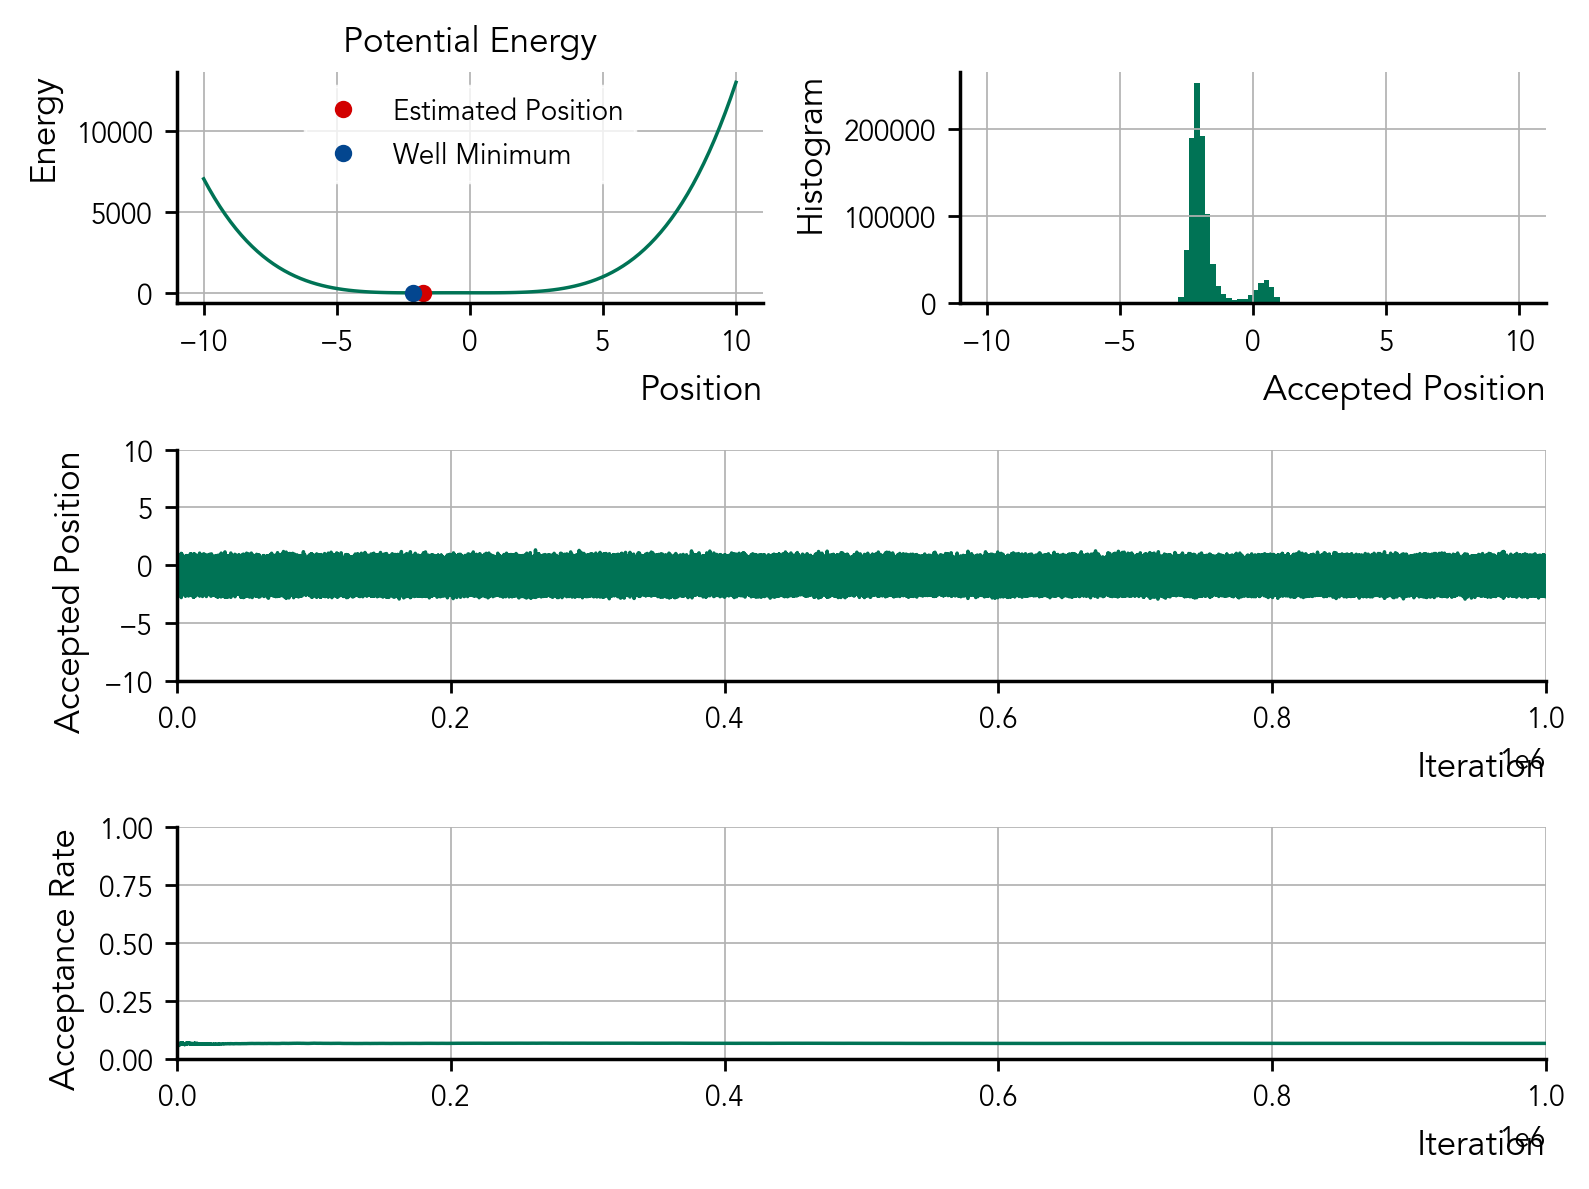

In [38]:
def potential_energy(x):
    ''' 
    Potential energy of a particle in a 1D potential well.
    '''
    return x**4 + 3*x**3 - 2.5*x

def monte_carlo_simulation(num_iterations, displacement_range, potential_energy = potential_energy, k_bT = 1, initial_position = None):
    ''' 
    Monte Carlo simulation of a particle in a 1D potential well.
    '''
    if initial_position is None:
        current_position = np.random.uniform(*displacement_range)
    else:
        current_position = initial_position
    accepted_positions = []
    num_accepted = 0
    acc_rate = np.zeros(num_iterations)
    
    for i in range(num_iterations):
        current_energy = potential_energy(current_position)
    
        displacement = np.random.uniform(*displacement_range)
        
        new_position = current_position + displacement
        new_energy = potential_energy(new_position)
    
        acceptance_probability = np.exp(-(new_energy - current_energy) / k_bT)
    
        if np.random.rand() <= acceptance_probability: # this is not correct
            current_position = new_position
            num_accepted += 1
    
        accepted_positions.append(current_position)
        acc_rate[i] = num_accepted / (i+1)

    estimated_position = np.mean(accepted_positions)
    return estimated_position, accepted_positions, acc_rate

num_iterations = 1000000 
displacement_range = (-10, 10) 

estimated_position, accepted_positions, acc_rate = monte_carlo_simulation(num_iterations, displacement_range)
print("Estimated Particle Position:", estimated_position)


# plotting
G = gridspec.GridSpec(3, 2)

ax = [plt.subplot(G[0, 0]), plt.subplot(G[1, :]), plt.subplot(G[0, 1]), plt.subplot(G[2, :])]

ax[0].set_title("Potential Energy")
ax[0].set_ylabel("Energy")
ax[0].set_xlabel("Position")
x = np.linspace(*displacement_range, 100)
ax[0].plot(x, potential_energy(x))
ax[0].plot(estimated_position, potential_energy(estimated_position), 'o', label="Estimated Position")
ax[0].plot(x[np.argmin(potential_energy(x))], np.min(potential_energy(x)), 'o', label="Well Minimum")
ax[0].legend()

ax[1].plot(accepted_positions)
ax[1].set_ylabel("Accepted Position")
ax[1].set_xlabel("Iteration")
ax[1].set_ylim(displacement_range)
ax[1].set_xlim(0, num_iterations)

# Plot a histogram of the accepted positions within the given range
ax[2].hist(accepted_positions, bins=100, range=displacement_range)
ax[2].set_xlabel("Accepted Position")
ax[2].set_ylabel("Histogram")

ax[3].plot(acc_rate)
ax[3].set_xlabel("Iteration")
ax[3].set_ylabel("Acceptance Rate")
ax[3].set_ylim(0, 1)
ax[3].set_xlim(0, num_iterations)

# tight layout
plt.tight_layout()

Based on the simulation the position of the particle is estimated to be at $x = -1.7$ (mean of the accepted positions).

## (b) Error estimate for $\langle x \rangle$

Using the block averaging method.


Text(0, 1, 's')

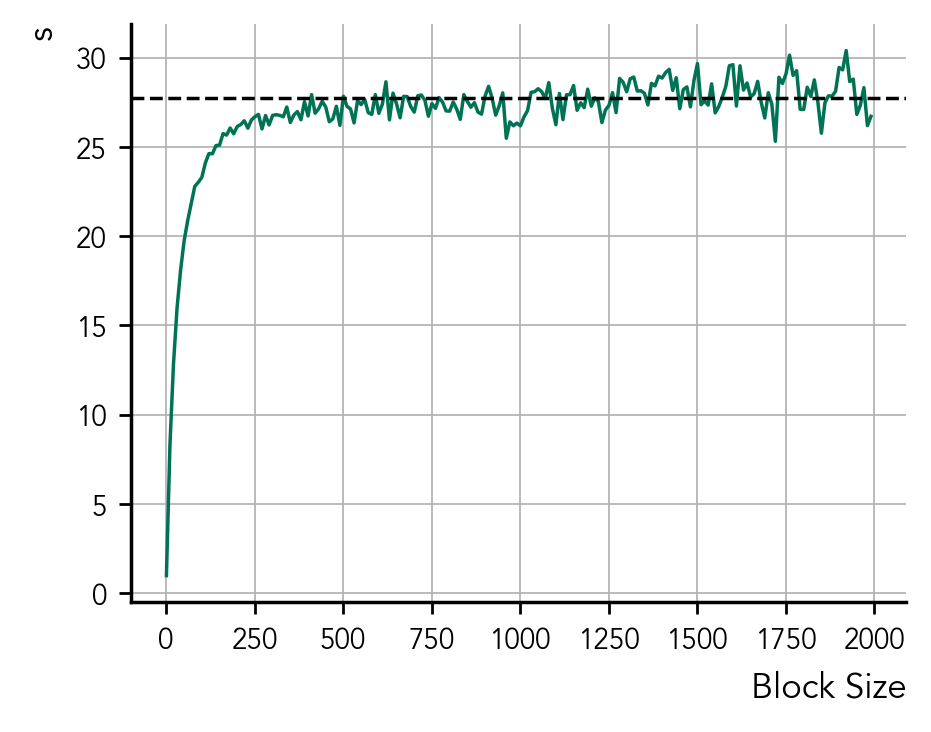

In [39]:
def block_average(sample, block_sizes):
    """Returns variances of block means for different block sizes."""
    
    variances = []
    
    for size in block_sizes:
        
        n_blocks = int(np.floor(len(sample) / size))
        
        block_averages = []
    
        for i in range(n_blocks):
            block = sample[i * size : (i+1) * size]
            block_averages.append(np.average(block))
    
        variances.append(np.var(block_averages))
        
    return variances

acc_pos_var_correlated = np.var(accepted_positions)

block_sizes = np.arange(1,2000,10)
# Block averaging
block_variances = block_average(accepted_positions, block_sizes)

# average samples 500 to 2000
get_plateau = block_sizes * block_variances/acc_pos_var_correlated
plateau_avg = np.mean(get_plateau[50:])

plt.figure(figsize=(4, 3))

plt.plot(block_sizes, get_plateau, label="Block Averaging")

# Mark plateau value
plt.axhline(plateau_avg, color="0", ls = "--")

plt.xlabel("Block Size")
plt.ylabel("s")

In [40]:
block_size = np.min(block_sizes[(np.abs(get_plateau - plateau_avg)<=0.3)])

print(f"Plateau value: \t\t {plateau_avg:.2f}")
print(f"Chosen block size: \t {block_size}")

acc_pos_std_corrected = np.sqrt(acc_pos_var_correlated /  len(accepted_positions) * block_size)

print(f"Position is estimated to be {estimated_position:.2f} +/- {acc_pos_std_corrected:.2f}")

est_1 = estimated_position
est_1_err = acc_pos_std_corrected

Plateau value: 		 27.74
Chosen block size: 	 391
Position is estimated to be -1.75 +/- 0.02


## (c) Behaviour at higher temperatures

### $k_B T = 0.1$

Estimated Particle Position: -2.1031370231385402


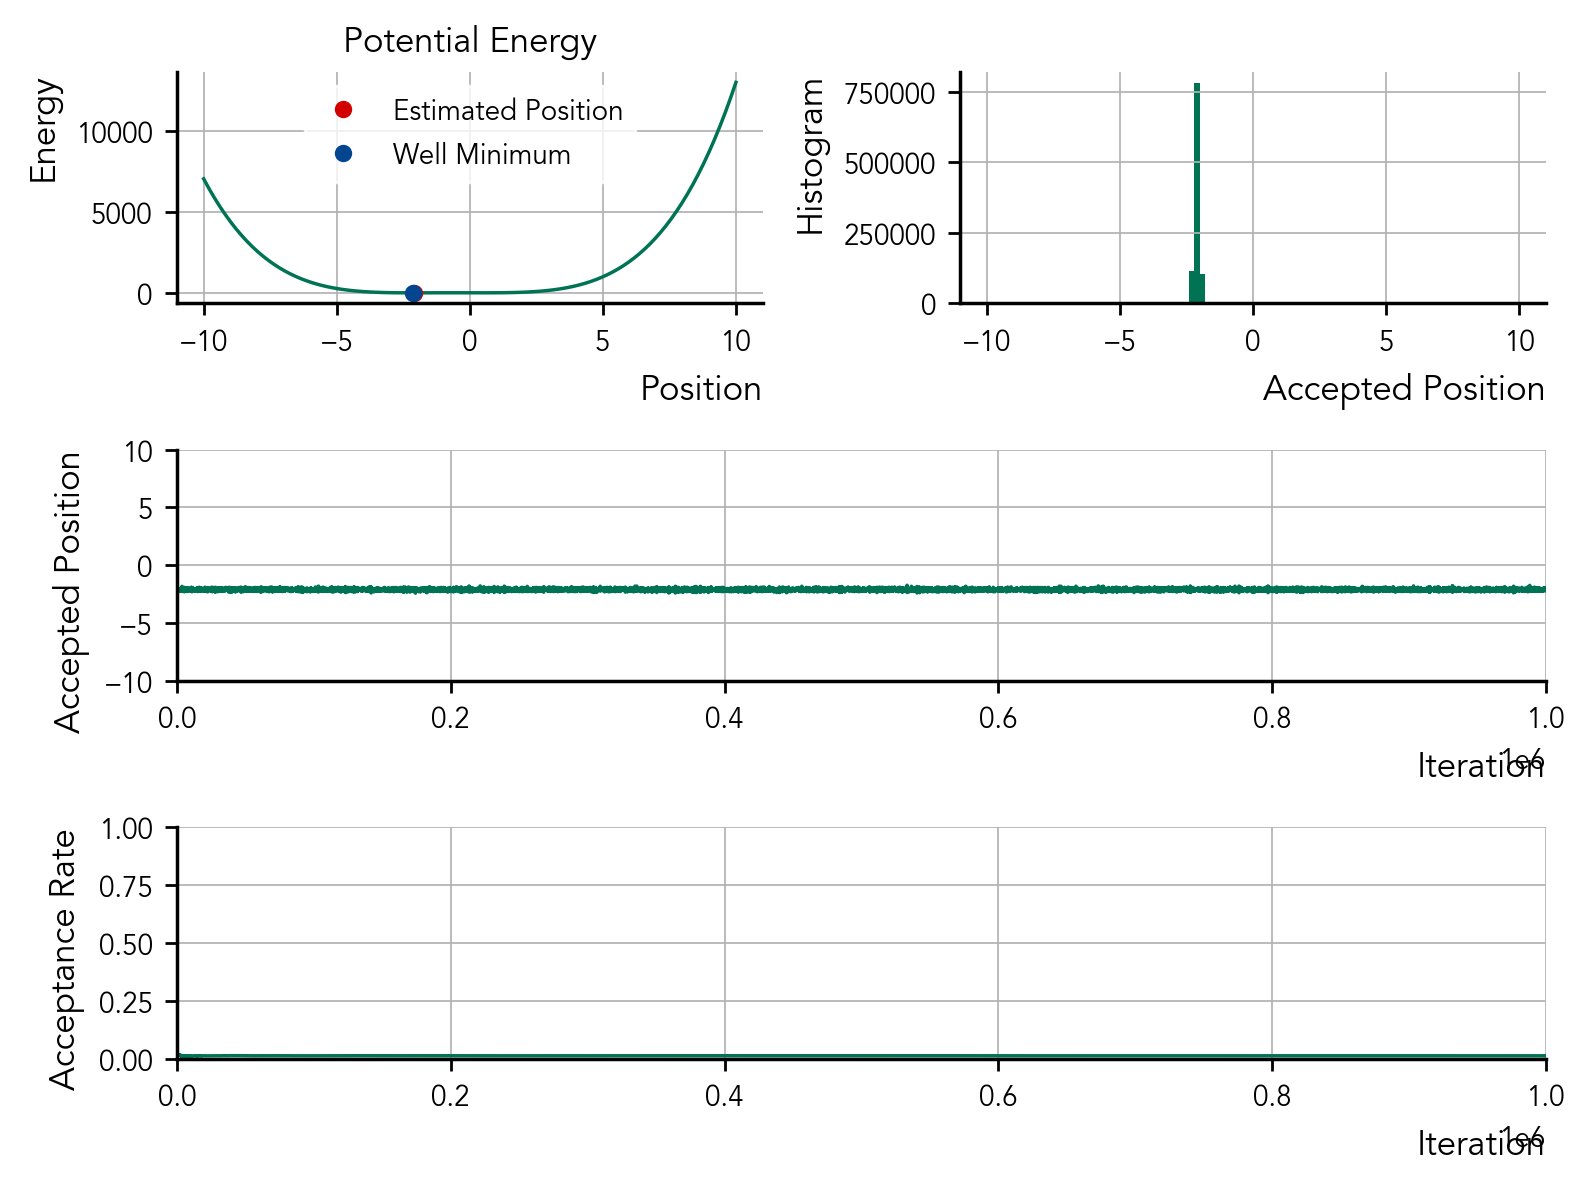

In [41]:
# for 
estimated_position, accepted_positions, acc_rate = monte_carlo_simulation(num_iterations, displacement_range, k_bT = 0.1, initial_position = -2.1)
print("Estimated Particle Position:", estimated_position)


# plotting
G = gridspec.GridSpec(3, 2)

ax = [plt.subplot(G[0, 0]), plt.subplot(G[1, :]), plt.subplot(G[0, 1]), plt.subplot(G[2, :])]

ax[0].set_title("Potential Energy")
ax[0].set_ylabel("Energy")
ax[0].set_xlabel("Position")
x = np.linspace(*displacement_range, 100)
ax[0].plot(x, potential_energy(x))
ax[0].plot(estimated_position, potential_energy(estimated_position), 'o', label="Estimated Position")
ax[0].plot(x[np.argmin(potential_energy(x))], np.min(potential_energy(x)), 'o', label="Well Minimum")
ax[0].legend()

ax[1].plot(accepted_positions)
ax[1].set_ylabel("Accepted Position")
ax[1].set_xlabel("Iteration")
ax[1].set_ylim(displacement_range)
ax[1].set_xlim(0, num_iterations)

# Plot a histogram of the accepted positions within the given range
ax[2].hist(accepted_positions, bins=100, range=displacement_range)
ax[2].set_xlabel("Accepted Position")
ax[2].set_ylabel("Histogram")

ax[3].plot(acc_rate)
ax[3].set_xlabel("Iteration")
ax[3].set_ylabel("Acceptance Rate")
ax[3].set_ylim(0, 1)
ax[3].set_xlim(0, num_iterations)

# tight layout
plt.tight_layout()

Text(0, 1, 's')

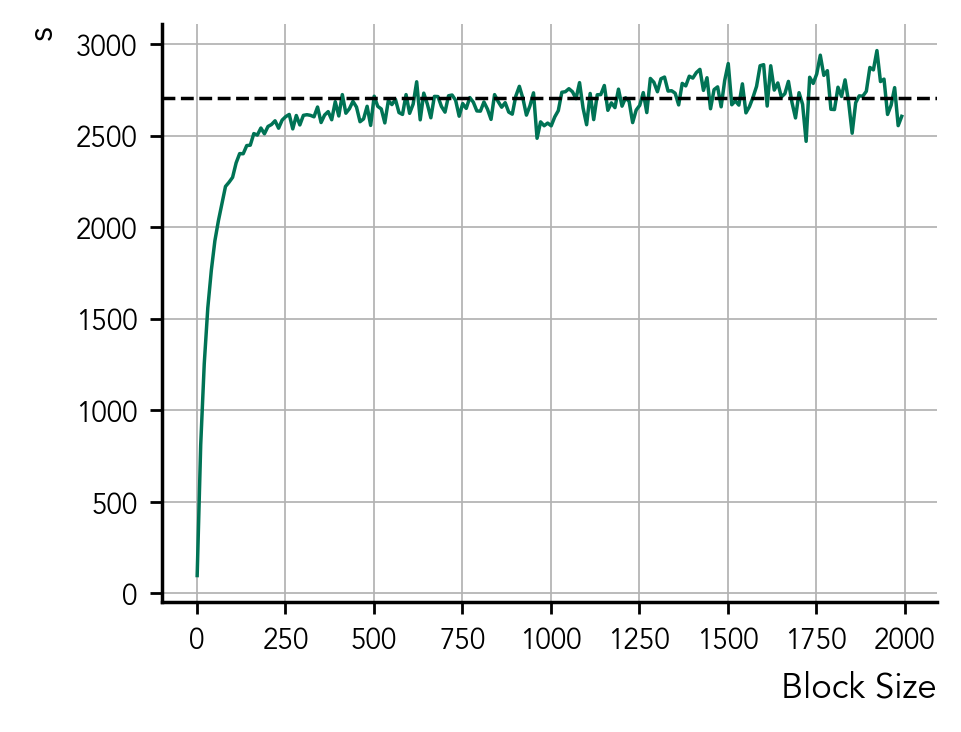

In [42]:
acc_pos_var_correlated = np.var(accepted_positions)

block_sizes = np.arange(1,2000,10)

# average samples 500 to 2000
get_plateau = block_sizes * block_variances/acc_pos_var_correlated
plateau_avg = np.mean(get_plateau[50:])
# Block averaging
block_variances = block_average(accepted_positions, block_sizes)

plt.figure(figsize=(4, 3))
plt.plot(block_sizes, get_plateau, label="Block Averaging")

# Mark plateau value
plt.axhline(plateau_avg, color="0", ls = "--")

plt.xlabel("Block Size")
plt.ylabel("s")

In [43]:
block_size = np.min(block_sizes[(np.abs(get_plateau - plateau_avg)<=0.3)])

print(f"Simulation temperature {0.1}")
print("-----------------------------")
print(f"Plateau value: \t\t {plateau_avg:.2f}")
print(f"Chosen block size: \t {block_size}")

acc_pos_std_corrected = np.sqrt(acc_pos_var_correlated /  len(accepted_positions) * block_size)

print(f"\nPosition is estimated to be {estimated_position:.5f} +/- {acc_pos_std_corrected:.5f}")

est_0_1 = estimated_position
est_0_1_err = acc_pos_std_corrected

ValueError: zero-size array to reduction operation minimum which has no identity

### $k_B T = 0.5$

Estimated Particle Position: -2.0372267306663003


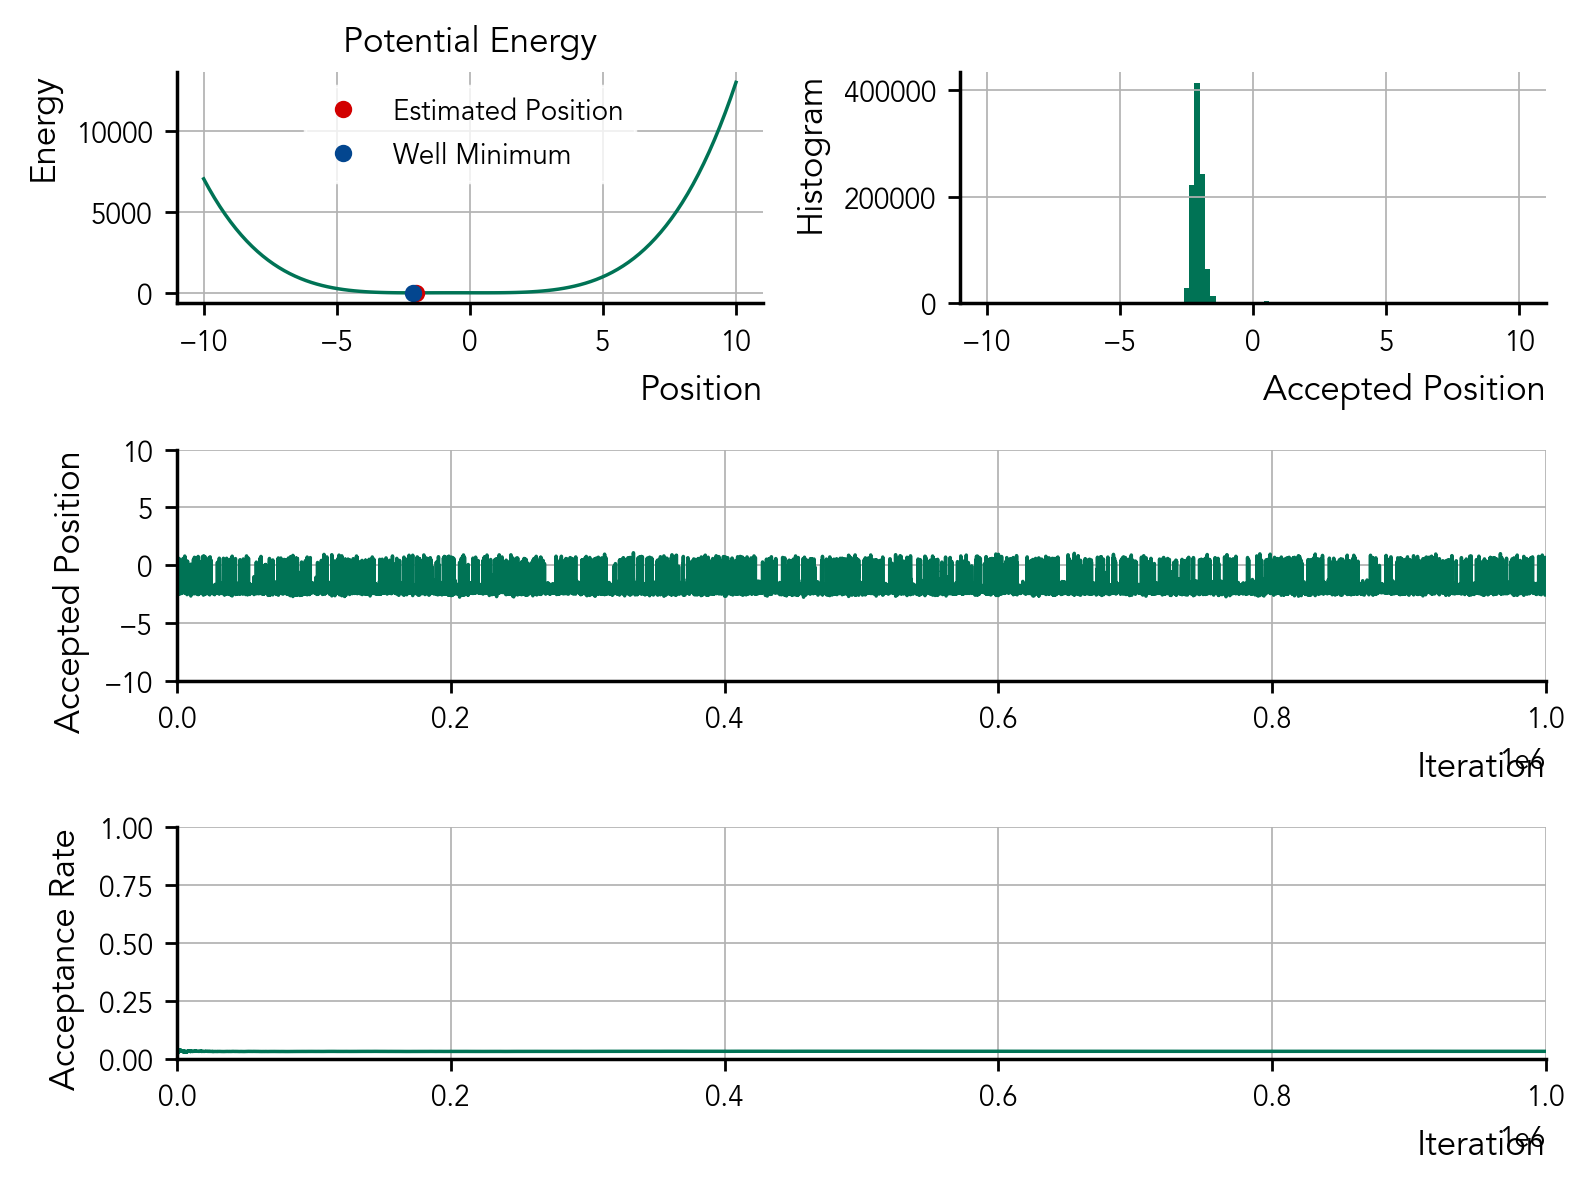

In [ ]:
# for 
estimated_position, accepted_positions, acc_rate = monte_carlo_simulation(num_iterations, displacement_range, k_bT = 0.5, initial_position = -2.1)
print("Estimated Particle Position:", estimated_position)


# plotting
G = gridspec.GridSpec(3, 2)

ax = [plt.subplot(G[0, 0]), plt.subplot(G[1, :]), plt.subplot(G[0, 1]), plt.subplot(G[2, :])]

ax[0].set_title("Potential Energy")
ax[0].set_ylabel("Energy")
ax[0].set_xlabel("Position")
x = np.linspace(*displacement_range, 100)
ax[0].plot(x, potential_energy(x))
ax[0].plot(estimated_position, potential_energy(estimated_position), 'o', label="Estimated Position")
ax[0].plot(x[np.argmin(potential_energy(x))], np.min(potential_energy(x)), 'o', label="Well Minimum")
ax[0].legend()

ax[1].plot(accepted_positions)
ax[1].set_ylabel("Accepted Position")
ax[1].set_xlabel("Iteration")
ax[1].set_ylim(displacement_range)
ax[1].set_xlim(0, num_iterations)

# Plot a histogram of the accepted positions within the given range
ax[2].hist(accepted_positions, bins=100, range=displacement_range)
ax[2].set_xlabel("Accepted Position")
ax[2].set_ylabel("Histogram")

ax[3].plot(acc_rate)
ax[3].set_xlabel("Iteration")
ax[3].set_ylabel("Acceptance Rate")
ax[3].set_ylim(0, 1)
ax[3].set_xlim(0, num_iterations)

# tight layout
plt.tight_layout()

Text(0, 1, 's')

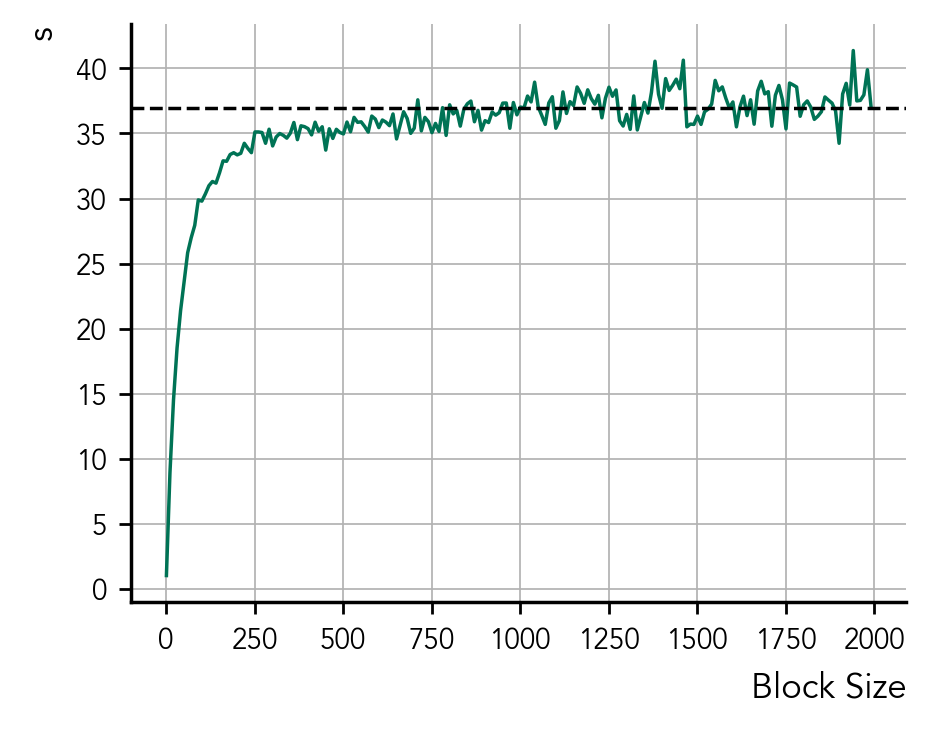

In [ ]:
acc_pos_var_correlated = np.var(accepted_positions)

block_sizes = np.arange(1,2000,10)
# Block averaging
block_variances = block_average(accepted_positions, block_sizes)

# average samples 500 to 2000
get_plateau = block_sizes * block_variances/acc_pos_var_correlated
plateau_avg = np.mean(get_plateau[50:])

plt.figure(figsize=(4, 3))
plt.plot(block_sizes, get_plateau, label="Block Averaging")

# Mark plateau value
plt.axhline(plateau_avg, color="0", ls = "--")

plt.xlabel("Block Size")
plt.ylabel("s")

In [ ]:
block_size = np.min(block_sizes[(np.abs(get_plateau - plateau_avg)<=0.3)])

print(f"Simulation temperature {0.5}")
print("-----------------------------")
print(f"Plateau value: \t\t {plateau_avg:.2f}")
print(f"Chosen block size: \t {block_size}")

acc_pos_std_corrected = np.sqrt(acc_pos_var_correlated /  len(accepted_positions) * block_size)

print(f"\nPosition is estimated to be {estimated_position:.5f} +/- {acc_pos_std_corrected:.5f}")

est_0_5 = estimated_position
est_0_5_err = acc_pos_std_corrected

Simulation temperature 0.5
-----------------------------
Plateau value: 		 36.97
Chosen block size: 	 1

Position is estimated to be -2.03723 +/- 0.00034


### $k_B T = 2$

Estimated Particle Position: -1.3283855036603063


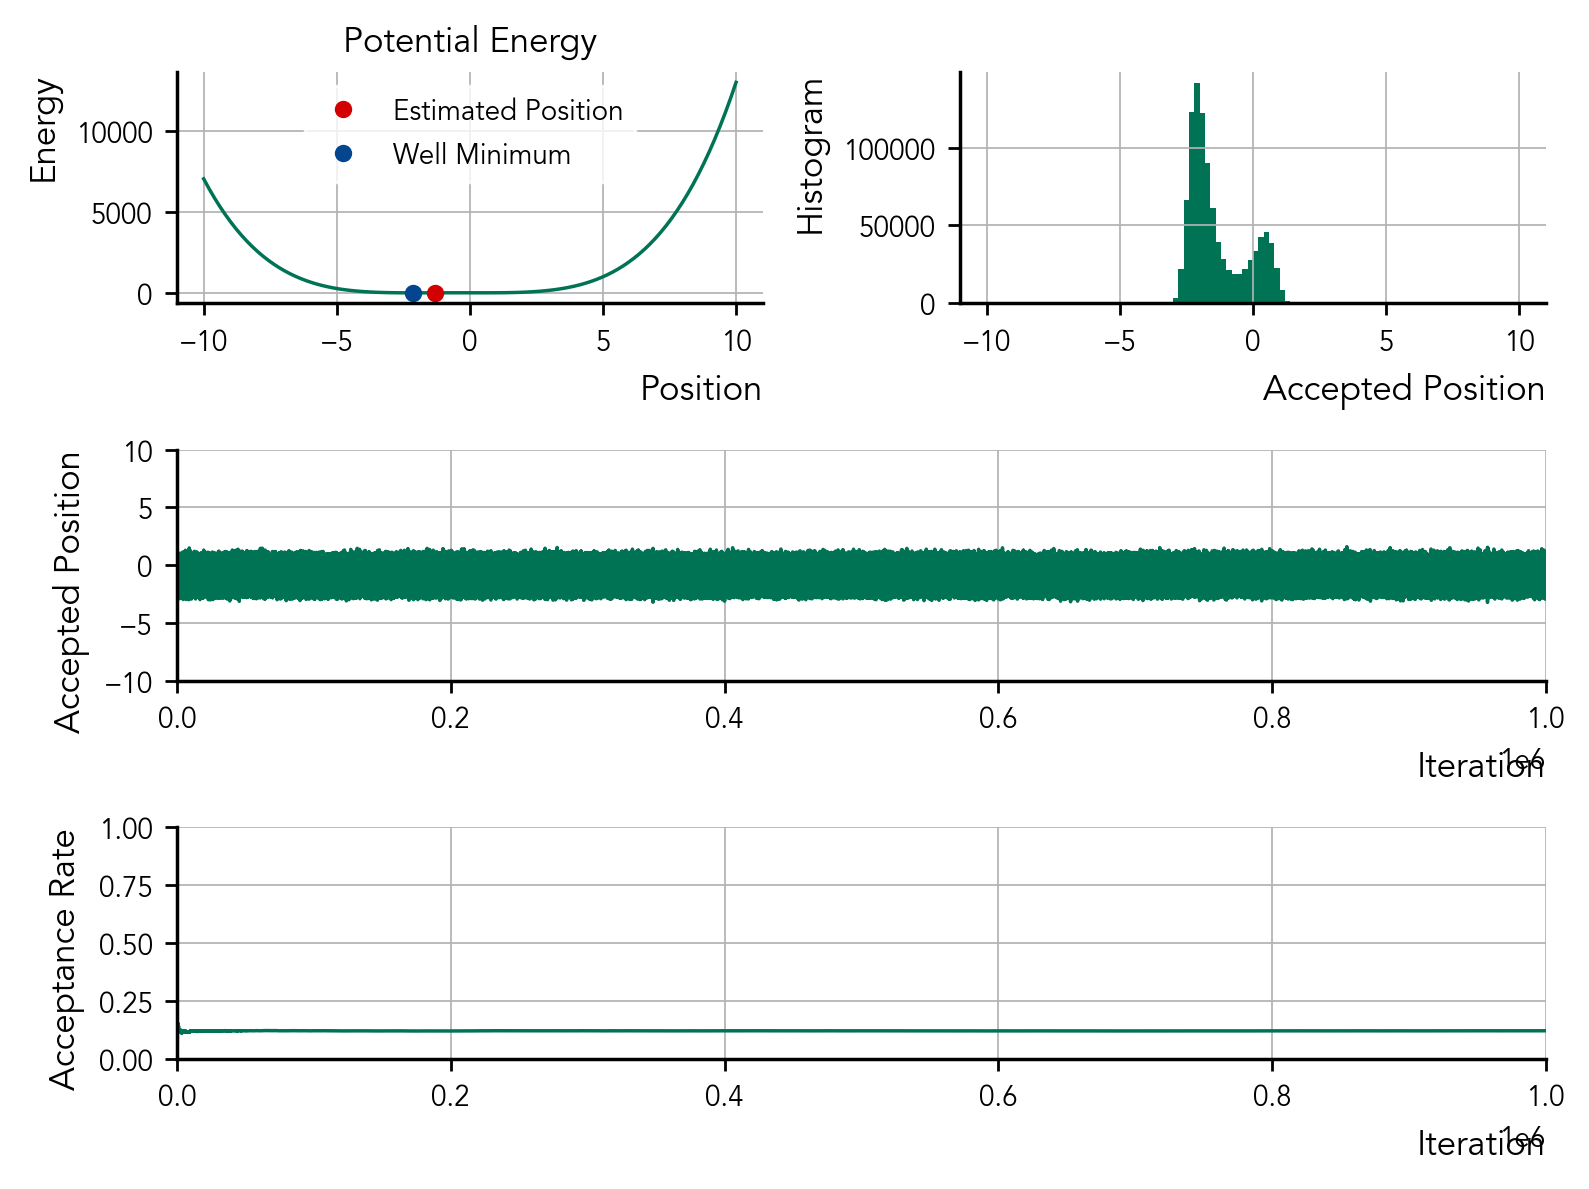

In [ ]:
# for 
estimated_position, accepted_positions, acc_rate = monte_carlo_simulation(num_iterations, displacement_range, k_bT = 2, initial_position = -2.1)
print("Estimated Particle Position:", estimated_position)


# plotting
G = gridspec.GridSpec(3, 2)

ax = [plt.subplot(G[0, 0]), plt.subplot(G[1, :]), plt.subplot(G[0, 1]), plt.subplot(G[2, :])]

ax[0].set_title("Potential Energy")
ax[0].set_ylabel("Energy")
ax[0].set_xlabel("Position")
x = np.linspace(*displacement_range, 100)
ax[0].plot(x, potential_energy(x))
ax[0].plot(estimated_position, potential_energy(estimated_position), 'o', label="Estimated Position")
ax[0].plot(x[np.argmin(potential_energy(x))], np.min(potential_energy(x)), 'o', label="Well Minimum")
ax[0].legend()

ax[1].plot(accepted_positions)
ax[1].set_ylabel("Accepted Position")
ax[1].set_xlabel("Iteration")
ax[1].set_ylim(displacement_range)
ax[1].set_xlim(0, num_iterations)

# Plot a histogram of the accepted positions within the given range
ax[2].hist(accepted_positions, bins=100, range=displacement_range)
ax[2].set_xlabel("Accepted Position")
ax[2].set_ylabel("Histogram")

ax[3].plot(acc_rate)
ax[3].set_xlabel("Iteration")
ax[3].set_ylabel("Acceptance Rate")
ax[3].set_ylim(0, 1)
ax[3].set_xlim(0, num_iterations)

# tight layout
plt.tight_layout()

Text(0, 1, 's')

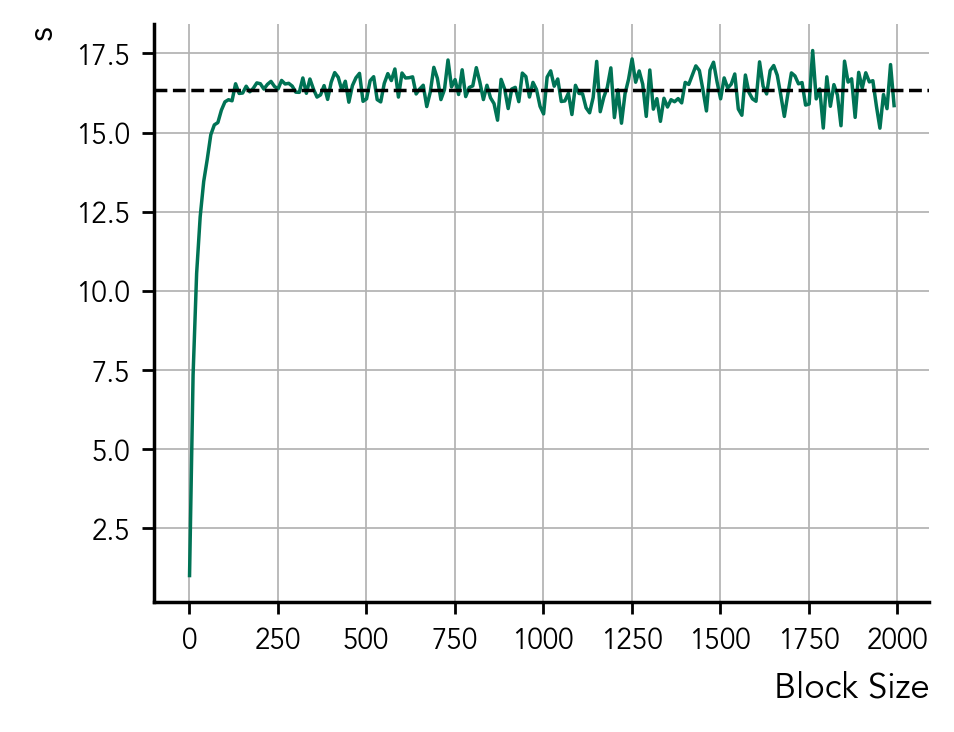

In [ ]:
acc_pos_var_correlated = np.var(accepted_positions)

block_sizes = np.arange(1,2000,10)

# Block averaging
block_variances = block_average(accepted_positions, block_sizes)
# average samples 500 to 2000
get_plateau = block_sizes * block_variances/acc_pos_var_correlated
plateau_avg = np.mean(get_plateau[50:])

plt.figure(figsize=(4, 3))
plt.plot(block_sizes, get_plateau, label="Block Averaging")

# Mark plateau value
plt.axhline(plateau_avg, color="0", ls = "--")

plt.xlabel("Block Size")
plt.ylabel("s")

In [ ]:
block_size = np.min(block_sizes[(np.abs(get_plateau - plateau_avg)<=0.3)])

print(f"Simulation temperature {2}")
print("-----------------------------")
print(f"Plateau value: \t\t {plateau_avg:.2f}")
print(f"Chosen block size: \t {block_size}")

acc_pos_std_corrected = np.sqrt(acc_pos_var_correlated /  len(accepted_positions) * block_size)

print(f"\nPosition is estimated to be {estimated_position:.5f} +/- {acc_pos_std_corrected:.5f}")

est_2 = estimated_position
est_2_err = acc_pos_std_corrected

Simulation temperature 2
-----------------------------
Plateau value: 		 16.36
Chosen block size: 	 1

Position is estimated to be -1.32839 +/- 0.00107


In [ ]:
# print table with results
print("Temperature \t\t Estimated Position \t\t Error")
print("---------------------------------------------------------------")
print(f"0.1 \t\t\t {est_0_1:.5f} \t\t\t {est_0_1_err:.5f}")
print(f"0.5 \t\t\t {est_0_5:.5f} \t\t\t {est_0_5_err:.5f}")
print(f"1 \t\t\t {est_1:.5f} \t\t\t {est_1_err:.5f}")
print(f"2 \t\t\t {est_2:.5f} \t\t\t {est_2_err:.5f}")


Temperature 		 Estimated Position 		 Error
---------------------------------------------------------------
0.1 			 -2.10098 			 0.00008
0.5 			 -2.03723 			 0.00034
1 			 -1.74651 			 0.00080
2 			 -1.32839 			 0.00107


Based on the previous results one can see that with increasing temperature the particle is more likely to be located further from the well minimum as the particle has more energy to move around. 

One can Also see that the acceptance rate is higher at higher temperatures. As the cold particle has less energy, thus it is less likely to move around, and the acceptance rate is lower. 

# Uncoupled spins

Considering system of $N$ independent spins $s_i \in \lbrace -1, 1\rbrace$ coupled to external magnetic field $H$ with the energy state $\nu = \lbrace s_1, s_2, \dots, s_N \rbrace$.
$$
E_\nu = - \sum_{i=1}^N s_i H
$$
With canonical partition function
$$
Z = 2^N \cosh^N (\beta H)
$$
and the mean magnetization with all the intermediate steps
$$
m = \frac{1}{N} \sum_{i = 1}^N s_i = - \frac{1}{N} \frac{\partial \ln Z}{\partial H} = \frac{1}{N} \frac{\partial \ln \cosh^N (\beta H)}{\partial H} = - \frac{1}{N} \frac{N \partial \ln \cosh (\beta H)}{\partial H} 
$$
$$
= \frac{\beta}{N} \frac{N \sinh (\beta H)}{\cosh (\beta H)} = \beta \tanh (\beta H)
$$
